<a href="https://colab.research.google.com/github/ask350/UM-Projects/blob/main/Forest%20cover/forest_cover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1 - import libraries

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import xgboost as xgb
import joblib

In [ ]:
# 2 - download and load data
url = "https://drive.google.com/file/d/1JbGpfPigNTzCZ_zsji_vA7q3ss_5NqGY/view?usp=sharing"
output = "forest_cover.csv"
gdown.download(url, output, quiet=False, fuzzy=True)

df = pd.read_csv("forest_cover.csv")
print("Dataset shape:", df.shape)
df.head()


Downloading...
From: https://drive.google.com/uc?id=1JbGpfPigNTzCZ_zsji_vA7q3ss_5NqGY
To: /content/forest_cover.csv
100%|██████████| 2.03M/2.03M [00:00<00:00, 55.7MB/s]

Dataset shape: (15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


previously have tried various methods like LR, XGB, NN, but highest accuracy was 88% tried to boost with hyper tuning, ensembling but to no further gain, trying feature engg with help of AI


/tmp/ipython-input-1473875096.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cover_Type", data=df, palette="Set2")


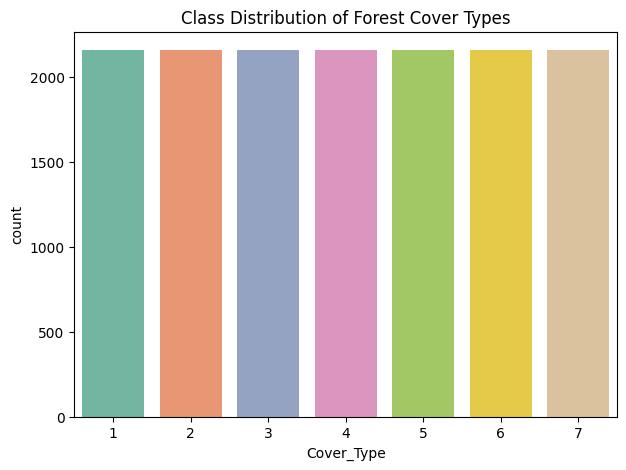

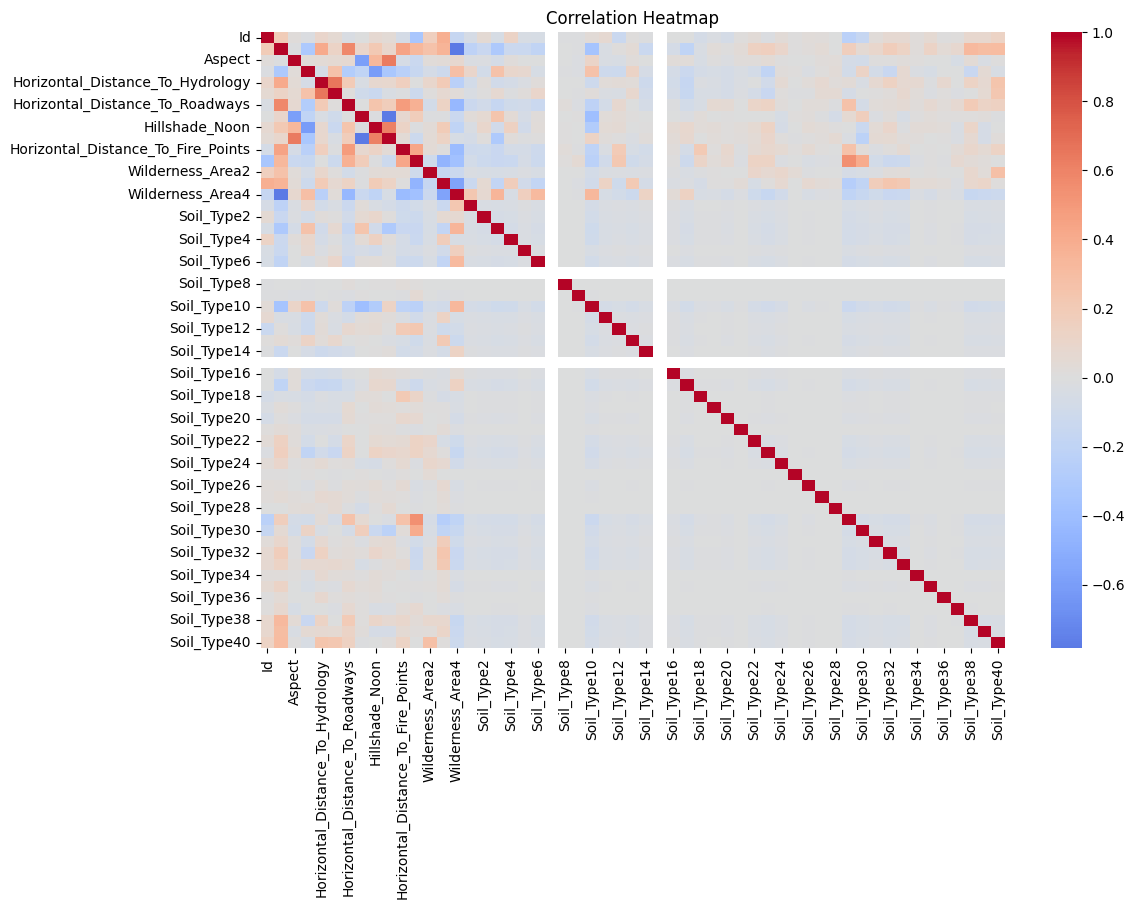

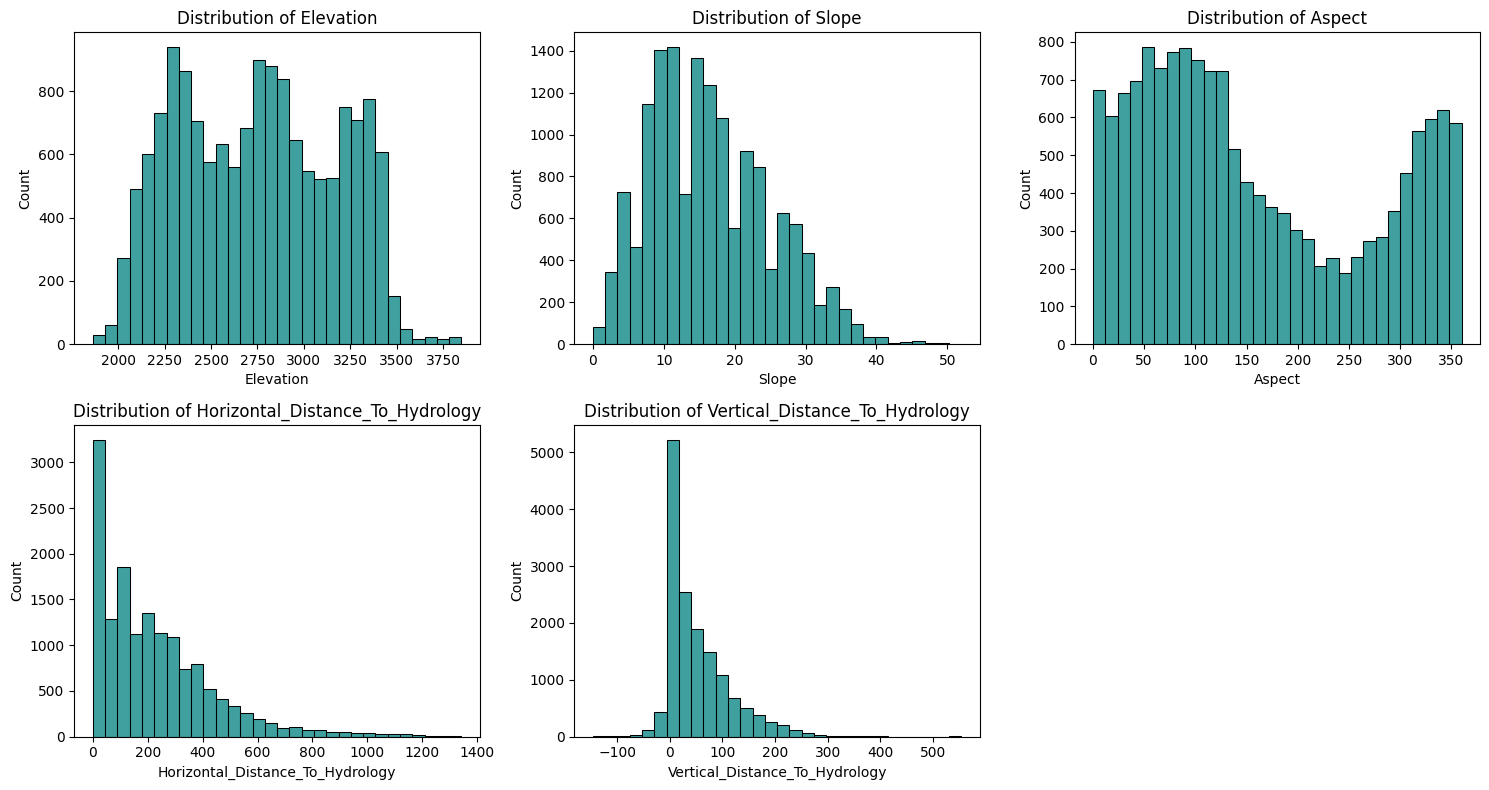

/tmp/ipython-input-1473875096.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cover_Label", y="Elevation", data=df, palette="Set3")


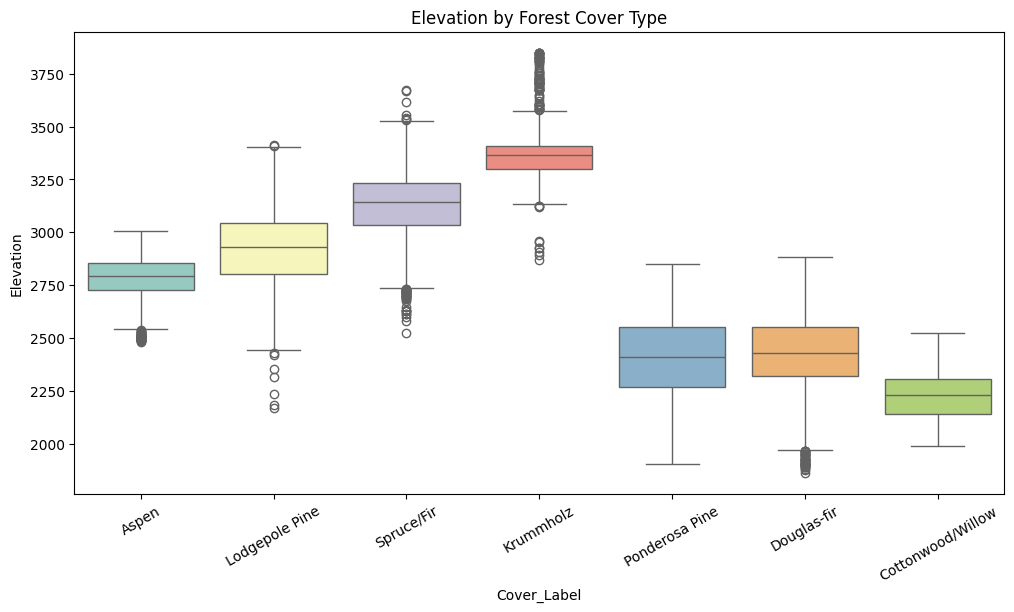

In [ ]:
# 3 - EDA

# Class distribution
plt.figure(figsize=(7,5))
sns.countplot(x="Cover_Type", data=df, palette="Set2")
plt.title("Class Distribution of Forest Cover Types")
plt.show()

# Correlation heatmap (numerical features only)
numeric_features = df.drop(columns=["Cover_Type"]).select_dtypes(include=np.number)
plt.figure(figsize=(12,8))
sns.heatmap(numeric_features.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

# Feature distributions
features_to_plot = ["Elevation", "Slope", "Aspect",
                    "Horizontal_Distance_To_Hydrology",
                    "Vertical_Distance_To_Hydrology"]
plt.figure(figsize=(15,8))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=False, color="teal")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Boxplot: Elevation by Cover Type
cover_labels = {
    1: "Spruce/Fir", 2: "Lodgepole Pine", 3: "Ponderosa Pine",
    4: "Cottonwood/Willow", 5: "Aspen", 6: "Douglas-fir", 7: "Krummholz"
}
df["Cover_Label"] = df["Cover_Type"].map(cover_labels)
plt.figure(figsize=(12,6))
sns.boxplot(x="Cover_Label", y="Elevation", data=df, palette="Set3")
plt.title("Elevation by Forest Cover Type")
plt.xticks(rotation=30)
plt.show()

In [ ]:
# 4 - feature engg

def feature_engineering(df):
    df = df.copy()

    df["Distance_To_Hydrology"] = np.sqrt(
        df["Horizontal_Distance_To_Hydrology"]**2 +
        df["Vertical_Distance_To_Hydrology"]**2
    )
    df["Abs_Vertical_Distance_To_Hydrology"] = np.abs(df["Vertical_Distance_To_Hydrology"])

    df["Road_Fire_Interaction"] = df["Horizontal_Distance_To_Roadways"] + df["Horizontal_Distance_To_Fire_Points"]
    df["Hydro_Road_Diff"] = df["Horizontal_Distance_To_Hydrology"] - df["Horizontal_Distance_To_Roadways"]
    df["Hydro_Fire_Diff"] = df["Horizontal_Distance_To_Hydrology"] - df["Horizontal_Distance_To_Fire_Points"]
    df["Road_Fire_Diff"] = df["Horizontal_Distance_To_Roadways"] - df["Horizontal_Distance_To_Fire_Points"]

    df["Mean_Hillshade"] = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].mean(axis=1)
    df["Hillshade_Range"] = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].max(axis=1) - \
                            df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].min(axis=1)

    df["Road_Hydro_Ratio"] = df["Horizontal_Distance_To_Roadways"] / (df["Distance_To_Hydrology"] + 1)
    df["Fire_Hydro_Ratio"] = df["Horizontal_Distance_To_Fire_Points"] / (df["Distance_To_Hydrology"] + 1)

    return df

df_fe = feature_engineering(df)
print("Shape after feature engineering:", df_fe.shape)



Shape after feature engineering: (15120, 67)


In [ ]:
# 5 - train test split as provided data is not divided

X = df_fe.drop(["Cover_Type", "Cover_Label"], axis=1, errors="ignore")
y = df_fe["Cover_Type"] - 1   # shift labels to 0–6

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Validation shape:", X_valid.shape)

Train shape: (12096, 65) Validation shape: (3024, 65)


In [ ]:
# 6a - logistic regression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

log_reg = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",
    solver="saga",         # better for large, multi-class datasets
    n_jobs=-1              # use all cores
)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_valid_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred_lr))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.6931216931216931


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# 6b - random forest

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)
print("Random Forest Accuracy:", accuracy_score(y_valid, y_pred_rf))

Random Forest Accuracy: 0.876984126984127


XGBoost Accuracy: 0.8878968253968254


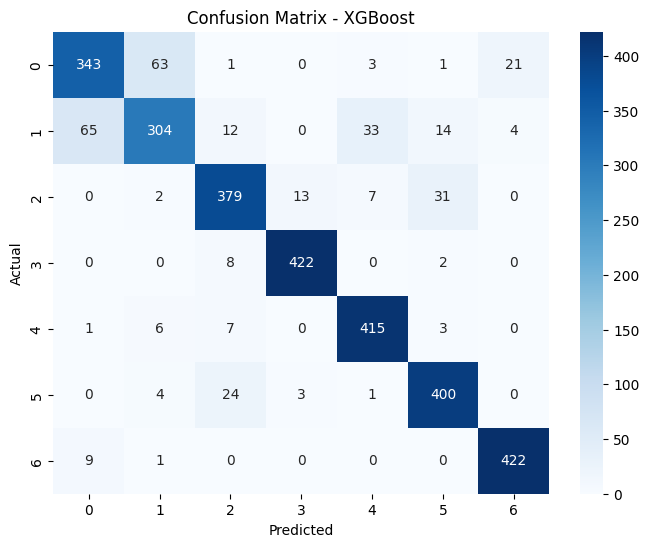

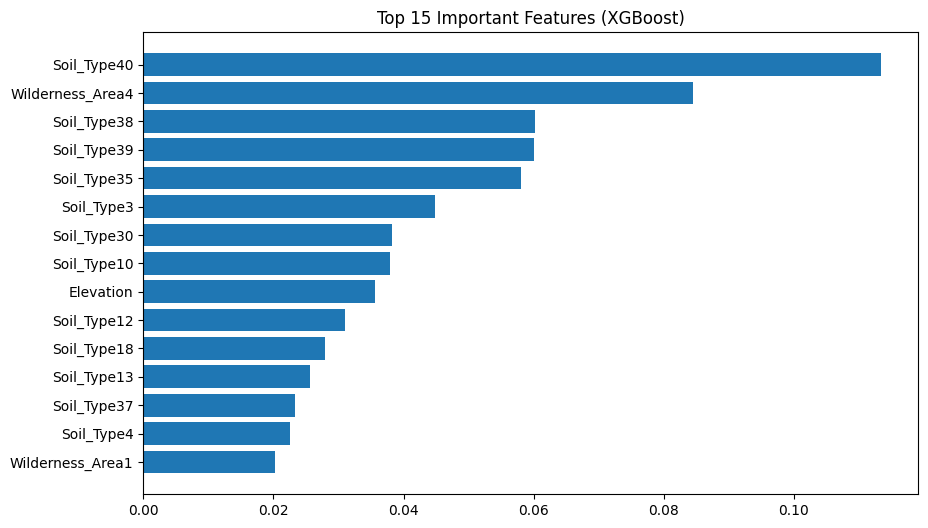

In [ ]:
# 6c - xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=12,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=7,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_valid)
print("XGBoost Accuracy:", accuracy_score(y_valid, y_pred_xgb))

# confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_valid, y_pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# feature importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-15:]
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 15 Important Features (XGBoost)")
plt.show()

/tmp/ipython-input-1472757381.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="viridis")


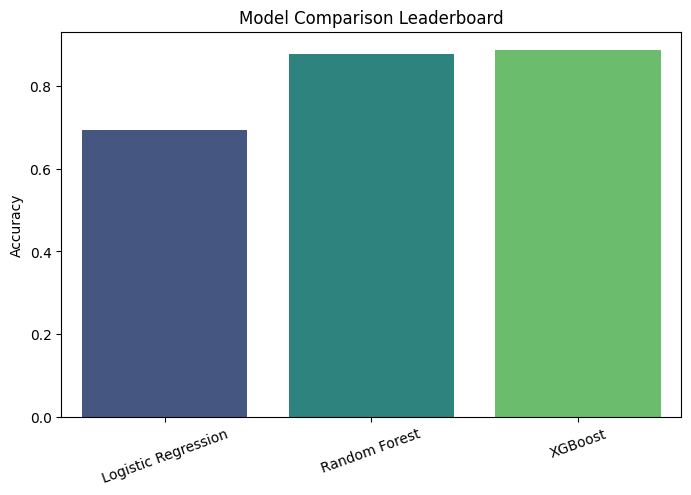

In [ ]:
# 7 - model comparision

model_scores = {
    "Logistic Regression": accuracy_score(y_valid, y_pred_lr),
    "Random Forest": accuracy_score(y_valid, y_pred_rf),
    "XGBoost": accuracy_score(y_valid, y_pred_xgb),
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="viridis")
plt.ylabel("Accuracy")
plt.title("Model Comparison Leaderboard")
plt.xticks(rotation=20)
plt.show()

In [ ]:
# 8 - save model
""" tried more tweaking but score started to drop """

import joblib
joblib.dump(xgb_model, "xgb_forest_cover.pkl")
print("Final XGBoost model saved as xgb_forest_cover.pkl")



Final XGBoost model saved as xgb_forest_cover.pkl


In [ ]:
""" - retrain xgb with new tweaked features

X = df.drop(["Cover_Type", "Cover_Label"], axis=1)
y = df["Cover_Type"] - 1

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

xgb_final = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=12,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=7,
    random_state=42,
    n_jobs=-1
)

xgb_final.fit(X_train, y_train)
y_pred_final = xgb_final.predict(X_valid)
print("🔹 Final XGBoost Accuracy:", accuracy_score(y_valid, y_pred_final))
"""

' - retrain xgb with new tweaked features\n\nX = df.drop(["Cover_Type", "Cover_Label"], axis=1)\ny = df["Cover_Type"] - 1\n\nX_train, X_valid, y_train, y_valid = train_test_split(\n    X, y, test_size=0.2, stratify=y, random_state=42\n)\n\nxgb_final = xgb.XGBClassifier(\n    n_estimators=800,\n    learning_rate=0.05,\n    max_depth=12,\n    subsample=0.8,\n    colsample_bytree=0.8,\n    objective="multi:softmax",\n    num_class=7,\n    random_state=42,\n    n_jobs=-1\n)\n\nxgb_final.fit(X_train, y_train)\ny_pred_final = xgb_final.predict(X_valid)\nprint("🔹 Final XGBoost Accuracy:", accuracy_score(y_valid, y_pred_final))\n'

In [ ]:
#  Step 9 - Test Hypothetical Data

# Pick a random row from validation set
sample = X_valid.iloc[0:1]
pred = xgb_model.predict(sample)[0]
print("Hypothetical test row predicted as:", cover_labels[pred+1])

Hypothetical test row predicted as: Cottonwood/Willow


In [ ]:
# Step 10: Manual Input for Prediction

def manual_prediction_dict(model, values_dict):
    row = pd.DataFrame([values_dict])
    row_fe = feature_engineering(row)
    row_fe = row_fe.reindex(columns=X.columns, fill_value=0)

    pred = model.predict(row_fe)[0]
    print("Predicted Cover Type:", cover_labels[pred+1])

# Example usage (you can change values below)
sample_values = {
    "Elevation": 3000,
    "Aspect": 45,
    "Slope": 10,
    "Horizontal_Distance_To_Hydrology": 100,
    "Vertical_Distance_To_Hydrology": 15,
    "Horizontal_Distance_To_Roadways": 500,
    "Horizontal_Distance_To_Fire_Points": 800,
    "Hillshade_9am": 220,
    "Hillshade_Noon": 230,
    "Hillshade_3pm": 180
}

manual_prediction_dict(xgb_model, sample_values)

Predicted Cover Type: Lodgepole Pine
